In [277]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

#modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae

from catboost import CatBoostRegressor

In [261]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.join(path, "ProcessedData")

In [262]:
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [287]:
class preprocess:
    
    def __init__(self,df):
        self.df = df
        self.non_unique = np.array(['자격유형', '공급유형', '임대건물구분','임대보증금', '임대료', '전용면적', '전용면적별세대수'])
        self.apt = df[df['임대건물구분']=='아파트']
        self.store= df[df['임대건물구분']=='상가']
        
    def new_y(self):
        try:
            self.df['등록차량수/총세대수'] = self.df.apply(lambda x : x['등록차량수']/x['총세대수'], axis=1)
            self.df['등록차량수/단지내주차면수'] = self.df.apply(lambda x : x['등록차량수']/x['단지내주차면수'], axis=1)
            self.y = np.array(['등록차량수','등록차량수/단지내주차면수','등록차량수/총세대수'])
        except:
            pass
        
    def no_duplicates(self): 
        
        self.newDF = self.df.drop(self.non_unique,axis=1).drop_duplicates().reset_index(drop=True)
    
    def merge(self,col,standard,oldDF,newDF,kind):
        
        sample = oldDF.groupby('단지코드').describe()[col].reset_index()
        for i in sample.index:
            for j in standard:
                code = sample.loc[i,'단지코드']
                val = sample.loc[i,j]
                ind = newDF[newDF['단지코드']==code].index
                newDF.loc[ind,kind+col+j] = val
        return newDF
    
    def category(self,x,dic):
        for i in dic.keys():
            if x in dic[i]:
                return int(i)
        
    def grouping(self,col,dic,oldDF,newDF):
        oldDF[col+'카테고리'] = oldDF[col].apply(lambda x : preprocess.category(self,x,dic))
        sample = pd.DataFrame(oldDF.groupby('단지코드')[col+'카테고리'].unique()).reset_index()
        for i in dic.keys():
            newDF[col+str(i)]=0
        for i in sample.index:
            code = sample.loc[i,'단지코드']
            val = sample.loc[i,col+'카테고리']
            ind = newDF[newDF['단지코드']==code].index
            for j in val:
                newDF.loc[ind,col+str(j)] = 1  
        newDF = newDF.drop(col+str(1),axis=1)
        return newDF
                    
    
    def process(self):
        
        #아파트 임대료, 임대보증금
        self.newDF = preprocess.merge(self,'임대료',['min','25%','50%','75%','max'],self.apt,self.newDF,'apt')
        self.newDF = preprocess.merge(self,'임대보증금',['min','25%','50%','75%','max'],self.apt,self.newDF,'apt')

        #상가 임대료, 임대보증금
        self.newDF = preprocess.merge(self,'임대료',['mean','std'],self.store,self.newDF,'store')
        self.newDF = preprocess.merge(self,'임대보증금',['mean','std'],self.store,self.newDF,'store')

        #상가 없는 경우 임대료 임대보증금 0으로 채움
        self.newDF = self.newDF.replace(np.nan, 0)

        # 자격유형 0,1 indicator variable
        dic = {'1': 'A' ,'2':['E','K'],'3':['D'],'4':['L','M','N','O'],'5':['B','H','I','G'],'6':'J','7':['C','F']}
        self.newDF = preprocess.grouping(self,'자격유형',dic,self.df,self.newDF)
        
        # 지역
        dic = {'1':['경상남도', '전라북도', '강원도', '광주광역시', '충청남도', '제주특별자치도', '울산광역시', '충청북도', '전라남도', '경상북도', '세종특별자치시'],'2':['경기도' ,'서울특별시', '대구광역시' ,'부산광역시', '대전광역시']}
        self.newDF = preprocess.grouping(self,'지역',dic,self.df,self.newDF)
        
        #공급유형
        self.df.loc[self.df['공급유형'].isin(['공공임대(10년)','공공임대(5년)']),'공급유형'] = '공공임대(5,10년)'
        sample = pd.DataFrame(self.df.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
        for i in sample.공급유형.unique():
            self.newDF[str(i)]=0
        for i in sample.index:
            code = sample.loc[i,'단지코드']
            col = sample.loc[i,'공급유형']
            val = sample.loc[i,'전용면적별세대수']
            ind = self.newDF[self.newDF['단지코드']==code].index
            self.newDF.loc[ind,col] = val
            
        # 전용면적
        self.newDF = preprocess.merge(self,'전용면적',['min','25%','50%','75%','max'],self.df,self.newDF,'area')
        
        # 공가수
        self.newDF['공가수'] =  self.newDF.apply(lambda x : x['공가수']*x['세대당_인구'],axis=1)
        
    
    def drop_col(self,col):
        self.newDF = self.newDF.drop(col,axis=1)
        return self.newDF
    
    def train_test(self,y_name,train=True):
        X = self.newDF.drop(['등록차량수','등록차량수/단지내주차면수','등록차량수/총세대수'],axis=1)
        X = pd.DataFrame(StandardScaler().fit_transform(X),columns=X.columns)
        self.y_name = y_name
        y = self.newDF[y_name]
        if y_name == '등록차량수/총세대수':
            X = X.drop(['총세대수'],axis=1)
        if y_name == '등록차량수/단지내주차면수':
            X = X.drop(['단지내주차면수'],axis=1)
        self.X = X
        if train == True:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.3,random_state=2021,shuffle=True)
            self.ind = self.X_test.index

    def catboost(self,fi=True):
        self.cb = CatBoostRegressor(random_state=2021).fit(self.X_train, self.y_train)
        pred = self.cb.predict(self.X_test)
        error = preprocess.error(self,self.y_name,pred)
        if fi == True:
            plt.figure(figsize=(12,16))
            sns.barplot(y = self.X_train.columns[np.argsort(self.cb.feature_importances_)], x = list(self.cb.feature_importances_[np.argsort(self.cb.feature_importances_)]))
        return error
    
    def error(self,y_name,pred):
        if y_name == '등록차량수/총세대수':
            real_y = np.array(self.newDF.loc[self.ind,'등록차량수'].values)
            real_pred = np.array(self.newDF.loc[self.ind,'총세대수'].values) * np.array(pred)
            return mae(real_y,real_pred)
        if y_name == '등록차량수/단지내주차면수':
            real_y = np.array(self.newDF.loc[self.ind,'등록차량수'].values)
            real_pred = np.array(self.newDF.loc[self.ind,'단지내주차면수'].values) * np.array(pred)
            return mae(real_y,real_pred)
        else:
            return mae(pred,self.y_test)
        
    def test_y(self):
        pred = self.cb.predict(self.X)
        if y_name == '등록차량수/총세대수':
            real_pred = np.array(testX['총세대수'].values) * np.array(pred)
            return read_pred
        if y_name == '등록차량수/단지내주차면수':
            real_pred = np.array(testX['단지내주차면수'].values) * np.array(pred)
            return read_pred
        else:
            return pred

In [288]:
pr = preprocess(train)
pr.new_y()
pr.no_duplicates()
pr.process()
result = pr.drop_col(['단지코드','지역','단지명','도로명주소','위도','경도','subway_name'])

Learning rate set to 0.032228
0:	learn: 0.3842360	total: 3.49ms	remaining: 3.49s
1:	learn: 0.3782797	total: 6.32ms	remaining: 3.15s
2:	learn: 0.3728380	total: 9.47ms	remaining: 3.15s
3:	learn: 0.3665061	total: 12.5ms	remaining: 3.12s
4:	learn: 0.3608609	total: 15.6ms	remaining: 3.1s
5:	learn: 0.3553274	total: 18.6ms	remaining: 3.08s
6:	learn: 0.3495887	total: 22ms	remaining: 3.11s
7:	learn: 0.3436663	total: 24.9ms	remaining: 3.09s
8:	learn: 0.3386743	total: 28.1ms	remaining: 3.09s
9:	learn: 0.3339239	total: 31ms	remaining: 3.07s
10:	learn: 0.3289372	total: 34.3ms	remaining: 3.08s
11:	learn: 0.3244055	total: 37.1ms	remaining: 3.05s
12:	learn: 0.3200657	total: 40ms	remaining: 3.04s
13:	learn: 0.3164118	total: 43ms	remaining: 3.03s
14:	learn: 0.3124435	total: 46.2ms	remaining: 3.03s
15:	learn: 0.3089343	total: 49.3ms	remaining: 3.03s
16:	learn: 0.3045333	total: 52.4ms	remaining: 3.03s
17:	learn: 0.3010638	total: 55.5ms	remaining: 3.03s
18:	learn: 0.2970872	total: 58.5ms	remaining: 3.02s
1

97.48881833092544

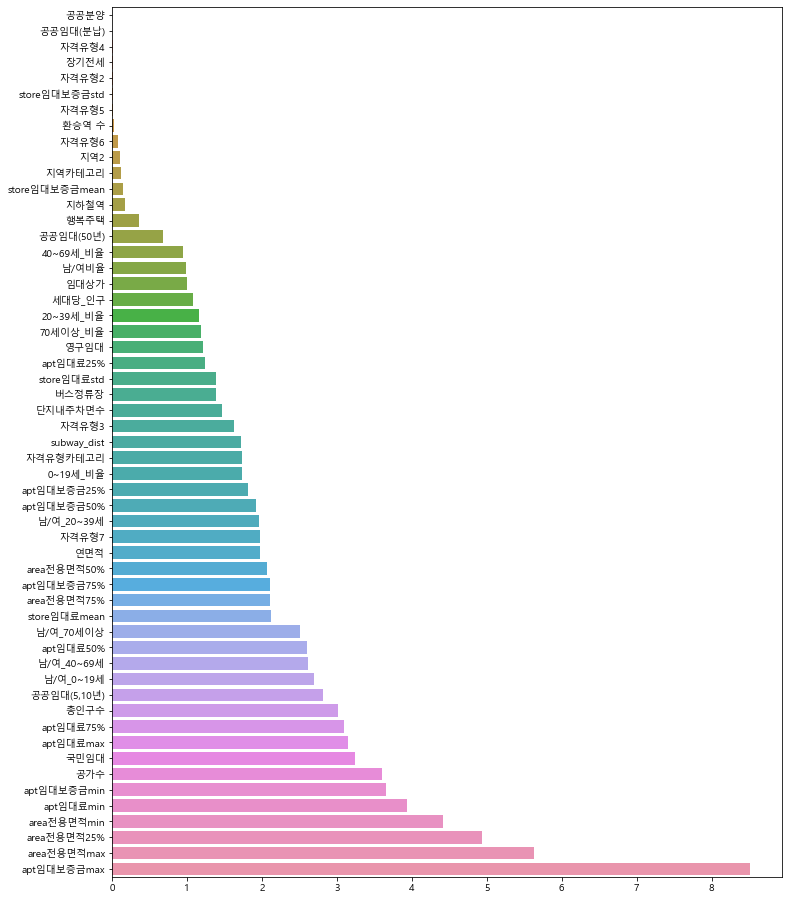

In [289]:
pr.train_test('등록차량수/총세대수')
pr.catboost()

In [ ]:
pr1 = preprocess(test)
pr1.new_y()
pr1.no_duplicates()
pr1.process()
result2 = pr1.drop_col(['단지코드','지역','단지명','도로명주소','위도','경도','subway_name'])
pr1.train_test('등록차량수',train=False)
pred = pr1.test_y()